In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pingouin as pg

sns.set()
sns.set_style("white")

In [2]:
df = pd.read_csv('allTogether.csv')

# remove ids and numbers
df = df.drop(['_id','question.number'], axis=1)
# groupNames, majLabel and colors are synonyms
df = df.drop(['question.groupNames','question.colors'], axis=1)

# encode categorial data
label_encoder = LabelEncoder()
df['question.majLabel'] = label_encoder.fit_transform(df['question.majLabel']).astype('float64')
df['user.language'] = label_encoder.fit_transform(df['user.language']).astype('float64')
df['user.age'] = label_encoder.fit_transform(df['user.age']).astype('float64')
df['user.edu'] = label_encoder.fit_transform(df['user.edu'].astype('str')).astype('float64')
df['user.gender'] = label_encoder.fit_transform(df['user.gender'].astype('str')).astype('float64')

# rND is labeled in reverse
df['question.new_rND'] = 2 - df['question.new_rND']

# add gender-focused version of the cv score (demographic parity)
# S=1 for male personas, S=0 for female personas
df['question.gender_cv'] = df['question.cv']
df.loc[df['question.majLabel']=='female', 'question.gender_cv'] = 2-df['question.cv']

# add gender-focused version of the rND score (demographic parity)
# S=1 for male personas, S=0 for female personas
df['question.gender_rND'] = df['question.new_rND']
df.loc[df['question.majLabel']=='female', 'question.gender_rND'] = 2-df['question.new_rND']

# add absolute version of the rND score (demographic parity)
df['question.abs_rND'] = df['question.new_rND']
df.loc[df['question.new_rND']>1, 'question.abs_rND'] = 2-df['question.new_rND']

# add absolute version of the cv score (demographic parity)
df['question.abs_cv'] = df['question.cv']
df.loc[df['question.cv']>1, 'question.abs_cv'] = 2-df['question.cv']

pd.set_option('display.max_columns', None)
df

/home/georg/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/georg/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


,rating,inconfidence,secondsElapsed,question.questionType,question.minSize,question.majSize,question.majLabel,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.cv,question.cluster,question.ordering_utility,question.sum_of_diff,question.rND,question.new_rND,user._id,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.gender_cv,question.gender_rND,question.abs_rND,question.abs_cv
0,0.89,0.84,36.534,selection,3,7,0.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.00,1.000000,NaN,NaN,1.000000,1.0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.714286,3,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,1.714286,NaN,NaN,0.285714
1,0.58,NaN,16.849,selection,5,5,0.0,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.80,0.854167,1.000000,0.927083,0.898551,1.0,0.5,0.75,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.600000,8,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.600000,NaN,NaN,0.600000
2,0.39,0.06,12.849,selection,4,6,1.0,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.75,1.000000,0.791045,0.895522,0.827160,0.5,1.0,0.75,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,1.333333,7,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,1.333333,NaN,NaN,0.666667
3,0.25,NaN,10.424,selection,4,6,0.0,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.50,0.395349,1.000000,0.697674,0.500000,1.0,0.6,0.80,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.750000,2,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.750000,NaN,NaN,0.750000
4,0.05,0.13,8.199,selection,1,9,0.0,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.00,NaN,0.000000,NaN,0.000000,0.0,1.0,0.50,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,2.000000,0,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,2.000000,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,0.14,NaN,6.142,ranking,4,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,0.297297,0.560000,0.250514,0.355276,ObjectId(5f7c49ed419e123366a885e

In [3]:
users = df['user._id'].unique()
mins = []
maxs = []
for user in users:
    min_rating = np.min(df[df['user._id'] == user].rating)
    mins = np.append(mins, min_rating)
    max_rating = np.max(df[df['user._id'] == user].rating)
    maxs = np.append(maxs, max_rating)
    df.loc[df['user._id'] == user, 'norm_rating'] = (df[df['user._id'] == user].rating - min_rating) / (max_rating - min_rating)
df

,rating,inconfidence,secondsElapsed,question.questionType,question.minSize,question.majSize,question.majLabel,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.cv,question.cluster,question.ordering_utility,question.sum_of_diff,question.rND,question.new_rND,user._id,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.gender_cv,question.gender_rND,question.abs_rND,question.abs_cv,norm_rating
0,0.89,0.84,36.534,selection,3,7,0.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.00,1.000000,NaN,NaN,1.000000,1.0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.714286,3,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,1.714286,NaN,NaN,0.285714,1.000000
1,0.58,NaN,16.849,selection,5,5,0.0,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.80,0.854167,1.000000,0.927083,0.898551,1.0,0.5,0.75,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.600000,8,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.600000,NaN,NaN,0.600000,0.643678
2,0.39,0.06,12.849,selection,4,6,1.0,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.75,1.000000,0.791045,0.895522,0.827160,0.5,1.0,0.75,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,1.333333,7,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,1.333333,NaN,NaN,0.666667,0.425287
3,0.25,NaN,10.424,selection,4,6,0.0,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.50,0.395349,1.000000,0.697674,0.500000,1.0,0.6,0.80,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.750000,2,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.750000,NaN,NaN,0.750000,0.264368
4,0.05,0.13,8.199,selection,1,9,0.0,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.00,NaN,0.000000,NaN,0.000000,0.0,1.0,0.50,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,2.000000,0,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,2.000000,NaN,NaN,0.000000,0.034483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,0.14,NaN,6.142,ranking,4,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,0.29729

# Overall Distribution of Ratings

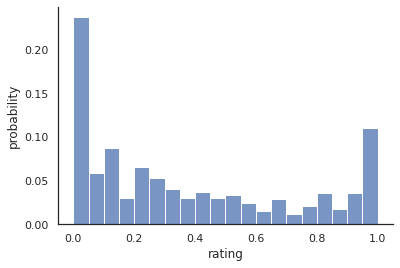

In [4]:
ax = sns.histplot(df, x='rating', bins=20, stat='probability')
ax.set(xlabel='rating', ylabel='probability')
sns.despine()

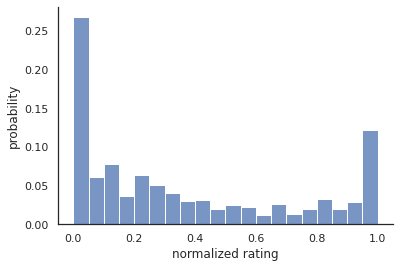

In [5]:
ax = sns.histplot(df, x='norm_rating', bins=20, stat='probability')
ax.set(xlabel='normalized rating', ylabel='probability')
sns.despine()

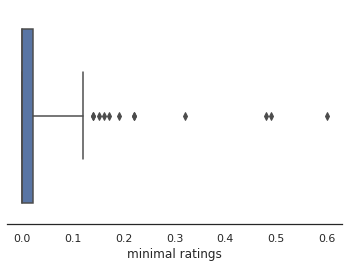

In [6]:
ax = sns.boxplot(x=mins, whis=5)
ax.set(xlabel='minimal ratings')
sns.despine(left=True)

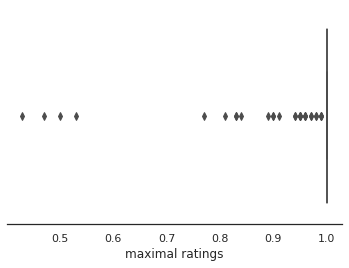

In [7]:
ax = sns.boxplot(x=maxs, whis=5)
ax.set(xlabel='maximal ratings')
sns.despine(left=True)

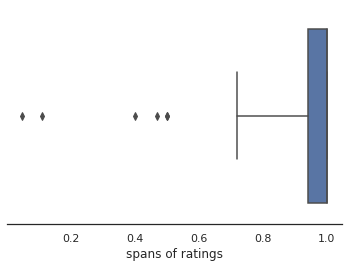

In [8]:
ax = sns.boxplot(x=maxs-mins, whis=5)
ax.set(xlabel='spans of ratings')
sns.despine(left=True)

In [9]:
ran_scores = [
    'question.ordering_utility',
    'question.sum_of_diff',
    'question.new_rND',
    'question.abs_rND',
    'question.rND'
]
df_sel = df.query("`question.questionType` == 'selection'").drop(ran_scores, axis=1)
df_sel

,rating,inconfidence,secondsElapsed,question.questionType,question.minSize,question.majSize,question.majLabel,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.cv,question.cluster,user._id,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.gender_cv,question.gender_rND,question.abs_cv,norm_rating
0,0.89,0.84,36.534,selection,3,7,0.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.714286,3,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,1.714286,NaN,0.285714,1.000000
1,0.58,NaN,16.849,selection,5,5,0.0,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.800000,0.854167,1.000000,0.927083,0.898551,1.0,0.500000,0.750000,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.600000,8,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.600000,NaN,0.600000,0.643678
2,0.39,0.06,12.849,selection,4,6,1.0,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.750000,1.000000,0.791045,0.895522,0.827160,0.5,1.000000,0.750000,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,1.333333,7,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,1.333333,NaN,0.666667,0.425287
3,0.25,NaN,10.424,selection,4,6,0.0,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.500000,0.395349,1.000000,0.697674,0.500000,1.0,0.600000,0.800000,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.750000,2,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.750000,NaN,0.750000,0.264368
4,0.05,0.13,8.199,selection,1,9,0.0,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.0,1.000000,0.500000,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,2.000000,0,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,2.000000,NaN,0.000000,0.034483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.70,0.82,35.312,selection,4,6,1.0,0.875000,0.500000,0.687500,0.8,0.965753,0.583333,0.774543,0.936709,1.000000,0.000000,0.500000,0.750000,1.000000,0.000000,0.500000,0.863636,0.8,1.000000,0.900000,0.833333,0.929293,1.000000,0.964646,0.933962,1.200000,0.000000,0.600000,0.916667,1.070707,0.000000,0.535354,0.929674,1.333333,

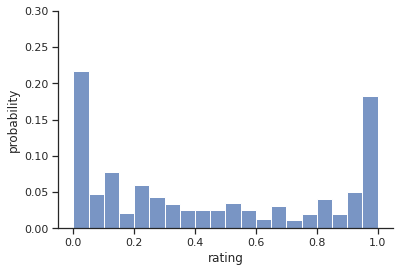

In [26]:
ax = sns.histplot(df_sel, x='rating', bins=20, stat='probability')
ax.set(xlabel='rating', ylabel='probability', ylim=(0, 0.3))
sns.despine()

In [11]:
sel_scores = [
    'question.tpr',
    'question.tnr',
    'question.bcr',
    'question.accuracy',
    'question.adj_tpr',
    'question.adj_tnr',
    'question.adj_bcr',
    'question.adj_accuracy',
    'question.tpr0',
    'question.tnr0',
    'question.bcr0',
    'question.accuracy0',
    'question.adj_tpr0',
    'question.adj_tnr0',
    'question.adj_bcr0',
    'question.adj_accuracy0',
    'question.tpr1',
    'question.tnr1',
    'question.bcr1',
    'question.accuracy1',
    'question.adj_tpr1',
    'question.adj_tnr1',
    'question.adj_bcr1',
    'question.adj_accuracy1',
    'question.s_tpr',
    'question.s_tnr',
    'question.s_bcr',
    'question.s_accuracy',
    'question.s_adj_tpr',
    'question.s_adj_tnr',
    'question.s_adj_bcr',
    'question.s_adj_accuracy',
    'question.cv',
    'question.abs_cv'
]
df_ran = df.query("`question.questionType` == 'ranking'").drop(sel_scores, axis=1)
df_ran

,rating,inconfidence,secondsElapsed,question.questionType,question.minSize,question.majSize,question.majLabel,question.cluster,question.ordering_utility,question.sum_of_diff,question.rND,question.new_rND,user._id,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.gender_cv,question.gender_rND,question.abs_rND,norm_rating
10,0.36,NaN,30.358,ranking,4,6,1.0,14,0.555556,0.622642,0.524177,0.523612,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.523612,0.523612,0.390805
11,0.59,NaN,12.189,ranking,4,6,1.0,16,0.594595,0.790000,0.444673,0.650439,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.650439,0.650439,0.655172
12,0.45,0.01,8.107,ranking,2,8,1.0,17,0.255814,0.494949,0.171153,0.997906,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.997906,0.997906,0.494253
13,0.61,0.06,11.920,ranking,5,5,0.0,12,0.717391,0.840336,0.272121,0.546572,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.546572,0.546572,0.678161
14,0.49,NaN,9.950,ranking,5,5,1.0,18,0.617647,0.718750,0.374144,0.996520,ObjectId(5f350096c9eafb2f751e4c21),0.0,0.86,1.0,0.37,0.34,0.74,0.0,0.50,1.0,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,NaN,0.996520,0.996520,0.540230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,0.14,NaN,6.142,ranking,4,6,1.0,17,0.297297,0.560000,0.250514,0.355276,ObjectId(5f7c49ed419e123366a885e2),0.0,1.00,1.0,0.53,1.00,0.81,0.0,0.21,1.0,0.77,0.81,0.13,780,360,0.55,4.0,2.0,4.0,3.0,4.5,NaN,0.355276,0.355276,0.000000
2706,0.26,NaN,11.163,ranking,5,5,0.0,12,0.657895,0.825688,0.237616,1.521316,ObjectId(5f7c49ed419e123366a885e2),0.0,1.00,1.0,0.53,1.00,0.81,0.0,0.21,1.0,0.77,0.81,0.13,780,360,0.55,4.0,2.0,4.0,3.0,4.5,NaN,1.521316,0.478684,0.139535
2707,0.21,NaN,13.815,ranking,5,5,0.0,13,0.318182,0.462264,0.249202,1.504024,ObjectId(5f7c49ed419e123366a885e2),0.0,1.00,1.0,0.53,1.00,0.81,0.0,0.21,1.0,0.77,0.81,0.13,780,360,0.55,4.0,2.0,4.0,3.0,4.5,NaN,1.504024,0.495976,0.081395
2708,0.81,0.10,9.210,ranking,4,6,1.0,14,0.948718,0.980392,0.547559,1.813790,ObjectId(5f7c49ed419e123366a885e2),0.0,1.00,1.0,0.53,1.00,0.81,0.0,0.21,1.0,0.77,0.81,0.13,780,360,0.55,4.0,2.0,4.0,3.0,4.5,NaN,1.813790,0.186210,0.779070


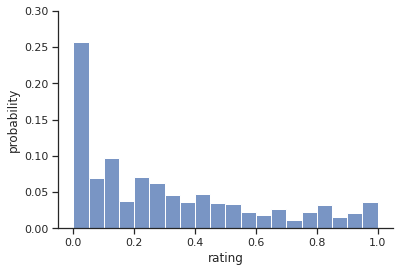

In [25]:
ax = sns.histplot(df_ran, x='rating', bins=20, stat='probability')
ax.set(xlabel='rating', ylabel='probability', ylim=(0, 0.3))
sns.despine()

# Overall distribution of answered questions

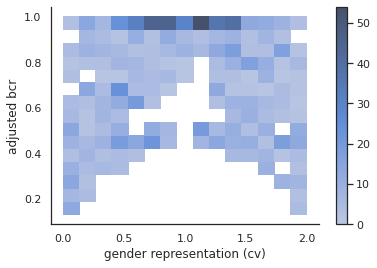

In [13]:
ax = sns.histplot(df_sel, x='question.gender_cv', y='question.adj_bcr', bins=15, cbar=True)
ax.set(ylabel='adjusted bcr', xlabel='gender representation (cv)')
sns.despine()

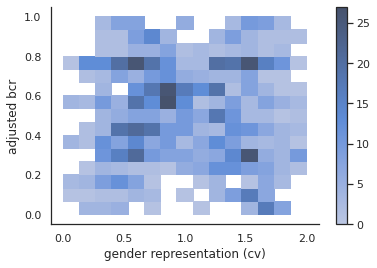

In [14]:
ax = sns.histplot(df_ran, x='question.gender_rND', y='question.ordering_utility', bins=15, cbar=True)
ax.set(ylabel='adjusted bcr', xlabel='gender representation (cv)')
sns.despine()

# Time to Answer

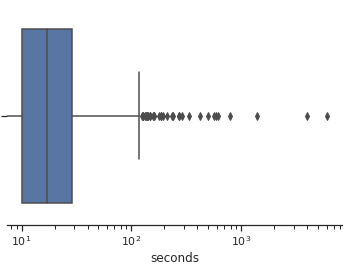

In [15]:
sns.set_style("ticks")
f, ax = plt.subplots()
ax.set_xscale("log")
sns.boxplot(data=df, x='secondsElapsed', whis=5)
#ax.set(xlim=(0.001, 10000))
ax.set(xlabel='seconds')
sns.despine(left=True)

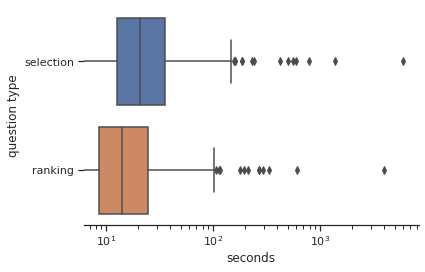

In [16]:
f, ax = plt.subplots()
ax.set_xscale("log")
sns.boxplot(data=df, x='secondsElapsed', y='question.questionType', whis=5)
ax.set(xlabel='seconds', ylabel='question type')
sns.despine(left=True)

In [17]:
print('Mean:', np.nanmean(df.secondsElapsed))
print('Median:', np.nanmedian(df.secondsElapsed))
print('Std. deviation:', np.nanstd(df.secondsElapsed))

Mean: 29.430196309963097
Median: 17.0765
Std. deviation: 144.51322169579757


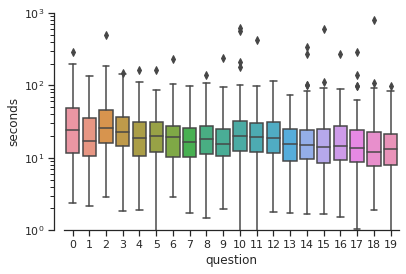

In [18]:
times = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
users = df['user._id'].unique()
df_sorted = df.sort_values(by=['user._id'])
for user in users:
    for i in range(20):
        times[i].append(df_sorted.at[df_sorted['user._id'].searchsorted(user) + i,'secondsElapsed'])
f, ax = plt.subplots()
ax.set(ylim=(1, 1000))
ax.set_yscale("log")
sns.boxplot(data=times, whis=5)
ax.set(xlabel='question', ylabel='seconds')
sns.despine(offset={'left': 10})

# Uncertainty

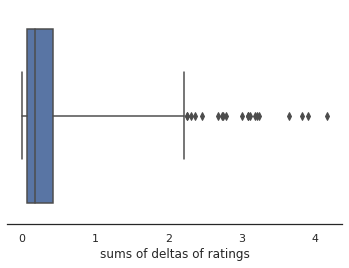

In [19]:
sns.set_style("white")
f, ax = plt.subplots()
sns.boxplot(data=df, x='inconfidence', whis=5)
ax.set(xlabel='sums of deltas of ratings')
sns.despine(left=True)

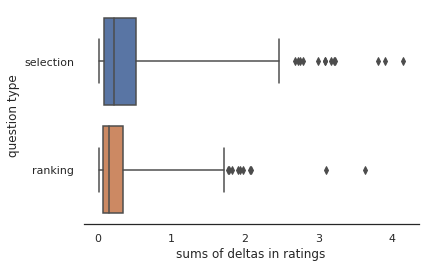

In [20]:
f, ax = plt.subplots()
sns.boxplot(data=df, x='inconfidence', y='question.questionType', whis=5)
ax.set(xlabel='sums of deltas in ratings', ylabel='question type')
sns.despine(left=True)

In [21]:
print('Mean:', np.nanmean(df.inconfidence))
print('Median:', np.nanmedian(df.inconfidence))
print('Std. deviation:', np.nanstd(df.inconfidence))

Mean: 0.3396169471851422
Median: 0.18000000000000005
Std. deviation: 0.45972407580684815


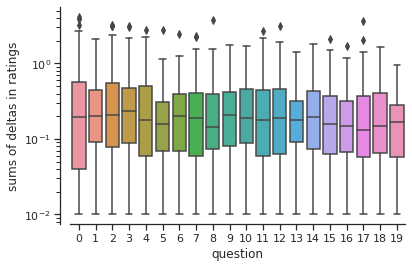

In [22]:
sns.set_style("ticks")
deltas = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
users = df['user._id'].unique()
df_sorted = df.sort_values(by=['user._id'])
for user in users:
    for i in range(20):
        deltas[i].append(df_sorted.at[df_sorted['user._id'].searchsorted(user) + i,'inconfidence'])
f, ax = plt.subplots()
#ax.set(ylim=(1, 1000))
ax.set_yscale("log")
sns.boxplot(data=deltas, whis=5)
ax.set(xlabel='question', ylabel='sums of deltas in ratings')
sns.despine(offset={'left': 10})